## 25-2. 음성과 오디오 데이터

위에서 언급한 오디오 데이터는 아날로그 데이터로서의 소리에 대한 설명이었습니다. 그러나 컴퓨터는 0과 1로만 이루어진 디지털 데이터만 취급 가능합니다. 우리가 흔히 볼 수 있는 소리들은 컴퓨터의 입력으로 들어가게 되면 어떤 과정을 거치게 될까요? 컴퓨터가 소리를 이해하는 과정을 살펴보겠습니다!

연속적인 아날로그 신호 중 가장 단순한 형태인 사인 함수(sine function)를 수식으로 표현하면 아래와 같습니다.

    * Asin(2*pi*f*t-theta)

는 진폭(amplitude)으로 위, 아래로 움직이는 소리의 크기를 나타냅니다. 는 주파수(frequnecy)로, 초당 진동 횟수를 나타냅니다. 즉, 소리의 세기를 나타냅니다. 주파수가 높으면 빠르게 진동해 소리의 세기가 커지게 됩니다. 은 위상이고 는 시간으로 정의합니다. 

### 아날로그 신호의 표본화(Sampling)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def single_tone(frequecy, sampling_rate=16000, duration=1):
    t = np.linspace(0, duration, int(sampling_rate))
    y = np.sin(2 * np.pi * frequecy * t)
    return y

y = single_tone(400)

1 사이클 동안 나타나는 연속시간 연속크기 아날로그 신호인 간단한 사인함수를 그려보겠습니다.

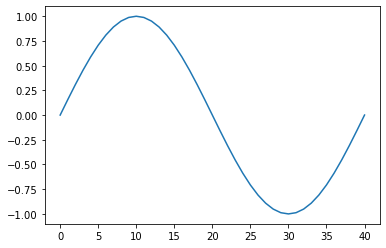

In [2]:
plt.plot(y[:41])
plt.show()

시간축 방향에서 일정 간격으로 샘플을 추출하여 이산 신호(discrete signal)로 변환시키는 과정을 표본화(Sampling)라고 부릅니다. 아래 그래프는 1 사이클 동안 나타나는 이산시간 연속크기 신호를 한번 출력해보도록 하겠습니다.

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


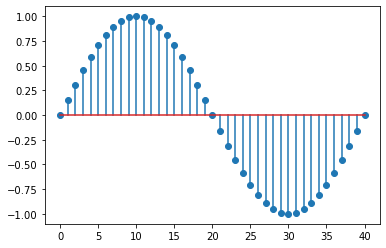

In [3]:
plt.stem(y[:41])
plt.show()

### Wave data 분석

In [4]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

### 데이터셋 살펴보기

 - npz 파일로 이뤄진 데이터이며, 
 - 각각 데이터는 "wav_vals", "label_vals"로 저장되어있습니다.

In [5]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [6]:
speech_data["wav_vals"][0]

array([-1.27418665e-04, -1.12644804e-04, -1.86756923e-04, ...,
       -1.62762426e-05, -4.93293861e-04, -3.55132594e-04], dtype=float32)

In [7]:
len(speech_data["wav_vals"][0])

8000


- 데이터셋은 1초 길이의 오디오 음성데이터 50620개로 이뤄져 있습니다.
- 주어진 데이터의 원래 Sample rate는 16000이지만, 8000으로 re-sampling해 사용하겠습니다.
- 모두 1초의 길이를 가지는 오디오 음성데이터이여서 각각 8000개의 sample data를 가지고 있습니다.

### 데이터 확인

In [8]:
import IPython.display as ipd
import random

# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  19863
Wave data shape :  (8000,)
label :  ['yes']


## 25-3. Train/Test 데이터셋 구성하기

Label data 처리

현재 단어의 정답은 Text 형태로 이뤄져있습니다. 학습을 위해서는 Text 데이터를 학습가능한 형태로 만들어줘야 합니다.

아래는 구분해야할 label 목록입니다.

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go' ]

이외 데이터들은 'unknown', 'silence'로 분류되어 있습니다.

In [9]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

Text 이루어진 데이터를 학습에 사용하기 위해서 index 형태로 바꿔주는 작업을 하겠습니다.
int로 이뤄진 index 작업을 통해서 Label data를 더 쉽게 사용할 수 있습니다.

In [10]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

### 학습을 위한 데이터 분리

sklearn의 train_test_split 함수를 이용해 train data와 test data를 분리하겠습니다.
test_size의 인자를 조절해주면, 설정해 준 값만큼 Test dataset의 비율을 조정할 수 있습니다.

In [11]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])

[[ 2.2814428e-03  2.8821588e-03 -2.0103923e-03 ...  1.0771671e-03
  -9.7122975e-05 -4.3639541e-03]
 [-3.2785512e-04 -6.4946583e-04 -6.0845783e-04 ...  6.1840308e-04
   3.3623099e-04  6.5465458e-04]
 [ 3.8253441e-02 -1.7335197e-02 -2.4574589e-02 ... -1.3974822e-02
   2.2620312e-03 -7.8699760e-02]
 ...
 [ 1.3956986e-02  2.0168167e-02  1.3741632e-02 ...  1.8445546e-02
   2.3620570e-02  1.7845092e-02]
 [-3.2113265e-04 -4.8635132e-04 -6.5334997e-04 ...  7.0958759e-04
   1.2375372e-03  1.1411059e-03]
 [ 1.5140572e-04  3.8526847e-04  3.0712545e-05 ... -4.9273782e-05
  -2.1782360e-04 -2.1258678e-04]]


### 데이터셋을 확인

In [12]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)


### Hyper-parameters setting

- 학습을 위한 하이퍼파라미터를 설정해줍니다.
- 모델 체크포인트 저장을 위한 체크포인트의 경로를 설정해줍니다.
- 후에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올때 사용합니다.

In [13]:
batch_size = 128
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel0042/aiffel/speech_recognition/models/wav'

### Data setting

tf.data.Dataset을 이용해서 데이터셋을 구성해주겠습니다.
from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있습니다.

map 함수는 dataset이 데이터를 불러올때마다 동작해주는 일종의 데이터 전처리 함수입니다.
첫번째 map 함수는 from_tensor_slice 에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정합니다.
map 함수는 중첩해서 사용이 가능합니다.

In [14]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

- tf.data.Dataset 함수를 구성

- batch는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수

In [15]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)


<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


## 25-4. Wave classification 모델 구현

### Model

- Audio 데이터는 1차원 데이터이기 때문에 데이터 형식에 맞도록 모델을 구성해주어야 합니다.
- Conv1D layer를 이용해서 모델을 구성해보겠습니다.
- Conv, batch norm, dropout, dense layer 등을 이용해 모델을 구성해보도록 하죠.

In [16]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)         

### Loss

 - 현재 라벨이 될 수 있는 12개의 단어 class를 가지고 있습니다.
 - 해당 class를 구분하기 위해서는 multi-class classification이 필요
 - 이를 수행하기 위한 Loss로 Categorical Cross-Entropy loss를 사용

In [17]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

### Training

### Callback

    - model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정할 수 있습니다.
    - 모델을 재사용하기위해서 모델 가중치를 저장하는 callback 함수를 추가해보겠습니다.

Model Checkpoint callback은 모델을 학습을 진행하며, fit 함수내 다양한 인자를 지정해 모니터하며 동작하게 설정할 수 있습니다.
현재 모델은 validation loss를 모니터하며, loss가 낮아지면 모델 파라미터를 저장하도록 구성되어 있습니다.

In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [ ]:
#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

### 학습 결과 Plot

model.fit 함수는 학습 동안의 결과를 return해줍니다.
return 값을 기반으로 loss와 accuracy를 그래프로 표현하겠습니다.
fit 함수에서 전달 받은 Loss와 Accuracy의 값을 이용해 모델이 어떻게 학습되고 있는지 볼 수 있습니다.
train loss와 val_loss의 차이가 커지는 경우 오버피팅이 일어나는 것이기 때문에 이를 수정할 필요가 있습니다.

출력된 그래프를 기반으로 모델의 학습이 어떻게 진행됐는지 확인해볼 수 있습니다.

In [40]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

TypeError: 'History' object is not subscriptable

### Evaluation

Test dataset을 이용해서 모델의 성능을 평가합니다.

실습삼아 checkpoint callback 함수가 저장한 weight를 다시 불러와서 테스트 준비를 해보겠습니다.

In [40]:
model_wav.load_weights(checkpoint_dir)

Test data을 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인하겠습니다.

In [41]:
results = model_wav.evaluate(test_dataset)

40/40 [==============================] - 10s 248ms/step - loss: 0.3260 - accuracy: 0.9034


In [42]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.326
accuracy value: 90.3398%


### Model Test

Test data 셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인해보아요.

In [43]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  left


In [44]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: left


## 25-5. Skip-Connection model을 추가


### Skip-Connection model 구현

이전 스텝에서 우리는 Conv1D 기반의 간단한 분류 모델을 구현해서 학습 및 테스트를 진행해 보았습니다. 간단한 모델임에도 정확도가 나쁘지 않았을 것입니다.

하지만 여러분들은 이미지처리 모델을 다루면서 ResNet 등 skip-connection을 활용한 모델들이 훨씬 안정적으로 높은 성능을 낼 수 있음을 배워왔을 것입니다. 그렇다면 이번 음성처리 모델에 적용해도 비슷한 개선 효과를 낼 수 있지 않을까요?

기존의 모델을 skip-connection이 추가된 모델로 변경해 학습을 진행해보겠습니다.
[ResNet 논문에 나오는 Skip-connection 개념]

그림에서 보듯이 위쪽의 데이터가 레이어를 뛰어넘어 레이어를 통과한 값에 더해주는 형식으로 구현됨을 확인할 수 있습니다.
Concat을 이용한 방식으로 구현하면 됩니다.

tf.concat([#layer output tensor, layer output tensor#], axis=#)

우리가 사용하는 데이터가 1차원 audio 데이터이기 때문에 1차원 데이터를 처리하는 모델을 구성해보겠습니다

In [45]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 8000, 32)     320         input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 8000, 32)     9248        conv1d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_8 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_21[0][0]                  
_______________________________________________________________________________________

모델 구성만 달라졌을 뿐, 그 외 Task구성이나 데이터셋 구성, 훈련 과정은 동일합니다.

In [46]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [47]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [49]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
355/355 [==============================] - ETA: 0s - loss: 1.1619 - accuracy: 0.6366
Epoch 00001: val_loss improved from inf to 1.04689, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 151s 425ms/step - loss: 1.1619 - accuracy: 0.6366 - val_loss: 1.0469 - val_accuracy: 0.6965
Epoch 2/10
355/355 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.8154
Epoch 00002: val_loss improved from 1.04689 to 0.57867, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 152s 429ms/step - loss: 0.6523 - accuracy: 0.8154 - val_loss: 0.5787 - val_accuracy: 0.8241
Epoch 3/10
355/355 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.8916
Epoch 00003: val_loss improved from 0.57867 to 0.41844, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 152s 429ms

In [50]:
model_skip_path = os.getenv("HOME")+'/aiffel/speech_recognition/history_wav_skip_model.h5'
model_wav_skip.save(model_skip_path)  #학습한 모델을 저장

학습결과의 시각화 및 evaluation 과정도 동일

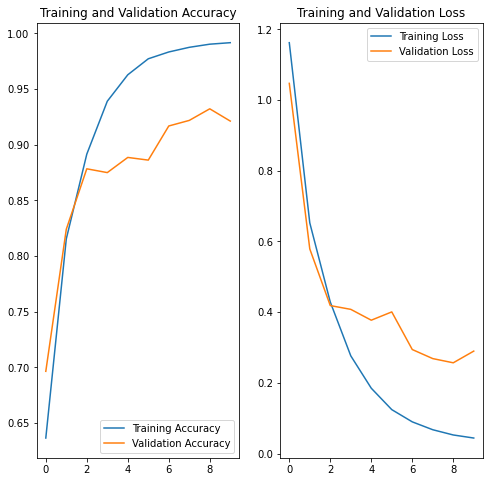

In [51]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

40/40 [==============================] - 6s 140ms/step - loss: 0.2545 - accuracy: 0.9330
loss value: 0.254
accuracy value: 93.3030%


In [53]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  no


In [55]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: no


### 25-6. Spectrogram

- Step2에서 사용한 샘플데이터를 이용하여 스펙트로그램을 생성
- 파이썬에서 제공하는 FFT 관련 라이브러리인 librosa를 설치

In [16]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [27]:
librosa.stft??

In [17]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


In [26]:
type(spec)

numpy.ndarray

In [27]:
li = []
li.append(spec)

In [29]:
li.append(spec)

In [31]:
len(li)

2

- 1차원의 Waveform 데이터가 2차원의 Spectrogram 데이터로 변환되었습니다.

- 그렇다면 방금 변환된 Spectrogram을 출력

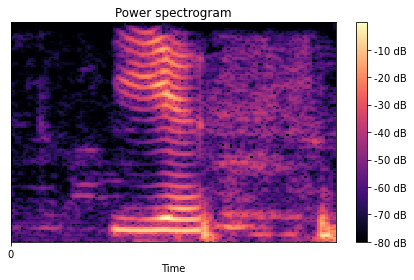

In [18]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

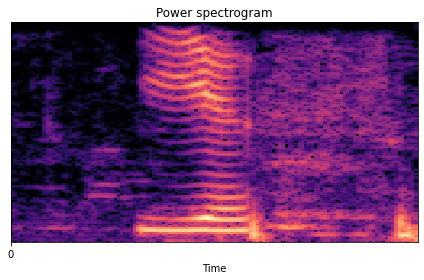

In [19]:
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
# plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

## 25-7. 프로젝트: Spectrogram classification 모델 구현

- 오늘 실습에서 1차원 Waveform 데이터를 입력받아 Text 라벨을 출력하는 모델을 기본 버전과 Skip-connection 버전으로 나누어 학습시켜 보았습니다. 

- 이번에는 2차원 Spectrogram 데이터를 입력받아 Text 라벨을 출력하는 모델 만들기
- 본 버전과 Skip-connection 버전으로 나누어 학습 시키기
- 모델 구조를 제외하고는 실습에서 제시된 것과 거의 동일하게 진행될 것

    1. 데이터 처리와 분류
        - 라벨 데이터 처리하기
        - sklearn의 rain_test_split함수를 이용하여 train, test 분리 

* 1차원 Waveform 데이터를 Spectrogram 데이터로 변환

In [20]:
len(speech_data["wav_vals"])

50620

In [23]:
type(speech_data["wav_vals"])

numpy.ndarray

In [31]:
from tqdm.notebook import tqdm

# spectrogram data 생성
# 시간이 너무 오래 걸려서 50620개 data 중 500개만 뽑아서 수행
spec_list = []

for i in tqdm(range(500)):
    spec_list.append(wav2spec(speech_data["wav_vals"][i]))

In [38]:
spec_arr = np.array(spec_list)

In [39]:
len(spec_arr)

500

In [34]:
label_data_500 = label_data[:500]
len(label_data_500)

500

In [40]:
train_spec, test_spec, train_spec_label, test_spec_label = train_test_split(spec_arr, label_data_500, test_size=0.1, shuffle=True)

### 데이터셋 확인

In [41]:
print("train_spec : ", train_spec.shape)
print("train_spec_label : ", train_spec_label.shape)
print("test_spec : ", test_spec.shape)
print("test_spec_label : ", test_spec_label.shape)

train_spec :  (450, 130, 126)
train_spec_label :  (450,)
test_spec :  (50, 130, 126)
test_spec_label :  (50,)


    2. 학습을 위한 하이퍼파라미터 설정

In [42]:
batch_size = 50
max_epochs = 10

# the save point
spec_checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'

spec_checkpoint_dir

'/home/aiffel0042/aiffel/speech_recognition/models/spec'

In [43]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

    3. 데이터셋 구성
        - tf.data.Dataset을 이용
        - from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
        - map과 batch를 이용한 데이터 전처리 

In [45]:
import tensorflow as tf

# for train
spec_train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_spec_label))
spec_train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(spec_train_dataset)

# for test
spec_test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_spec_label))
spec_test_dataset = test_dataset.batch(batch_size=batch_size)
print(spec_test_dataset)


<BatchDataset shapes: ((None, None, 8000, 1), (None, None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, None, 8000, 1), (None, None, 12)), types: (tf.float32, tf.float32)>


4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

    - 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 
    - 혹은 Conv2D layer를 적용 가능

        * batchnorm, dropout, dense layer 등을 이용
        * 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
        * 모델 가중치를 저장하는 checkpoint callback 함수 추가

    4-1. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
        * loss, accuracy를 그래프로 표현 

    4-2. Test dataset을 이용해서 모델의 성능을 평가
        * 저장한 weight 불러오기
        * 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [57]:
from tensorflow.keras import layers

input_tensor_spec = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor_spec)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor_spec = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor_spec, output_tensor_spec)

model_spec.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 130, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 65, 63, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 65, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 31, 64)       

In [59]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [53]:
checkpoint_dir_spec = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_skip'
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_spec,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [56]:
len(test_spec)

50

In [60]:
#30분 내외 소요
history_spec = model_spec.fit(spec_train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=spec_test_dataset,
                    validation_steps=len(test_spec) // batch_size
                    )

Epoch 1/10


ValueError: in user code:

    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, None, 12) and (None, 12) are incompatible
